In [38]:
# Standard imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [39]:
# Constants:

# Contains 1.6M samples
PATH_DATA = "./input/training.1600000.processed.noemoticon.csv"

# GloVe Twitter embeddings: 2B tweets, 27B tokens, 1.2M vocab, uncased,200-dimensional
PATH_EMB = "./input/glove.twitter.27B.200d.txt"
N_EMB = 200 # Dimensions of the embeddings

# Using fastText Word vectors trained on Wikipedia 2017, UMBC webbase corpus, and statmt.org
# PATH_EMB = "../input/fasttext-wikinews/wiki-news-300d-1M.vec"
# N_EMB = 300

# Number of samples to be taken
LIMIT = 1600000

# Fraction of samples to be used for training set
N_TRAIN = 0.9

# Size of each sequence to be embedded:
N_SEQ = 0 # Chosen later based on the histogram of the lengths

## Data reading and pre-processing

In [40]:
# Function that returns the processed dataframe
def loadDF(n_samples):
    
    # Read
    df = pd.read_csv(
        PATH_DATA, 
        encoding = "latin", # No encoding results in decode error 
        header = None
    )
    
    # Drop columns which aren't needed
    df.drop(labels = [1,2,3,4], axis = "columns", inplace = True)
    df.columns = ["Label", "Text"]
    
    # Relabel 0 -> 0 and 4 -> 1 (0:Negative, 1:Positive)
    df.replace(to_replace = 4, value = 1, inplace = True)
    
    # Training on 1.6M samples takes a lot of time, we train on a smaller randomized subset of the data
    df = df.sample(n = n_samples, random_state = 42)
    
    return df

In [41]:
df = loadDF(LIMIT)
print("Class distribution:\n{}".format(df["Label"].value_counts()))

Class distribution:
1    800000
0    800000
Name: Label, dtype: int64


## Cleaning the data:

In [42]:
# Check for null values
check = df.isnull().sum()
print(check)

Label    0
Text     0
dtype: int64


## WordCloud visualization:

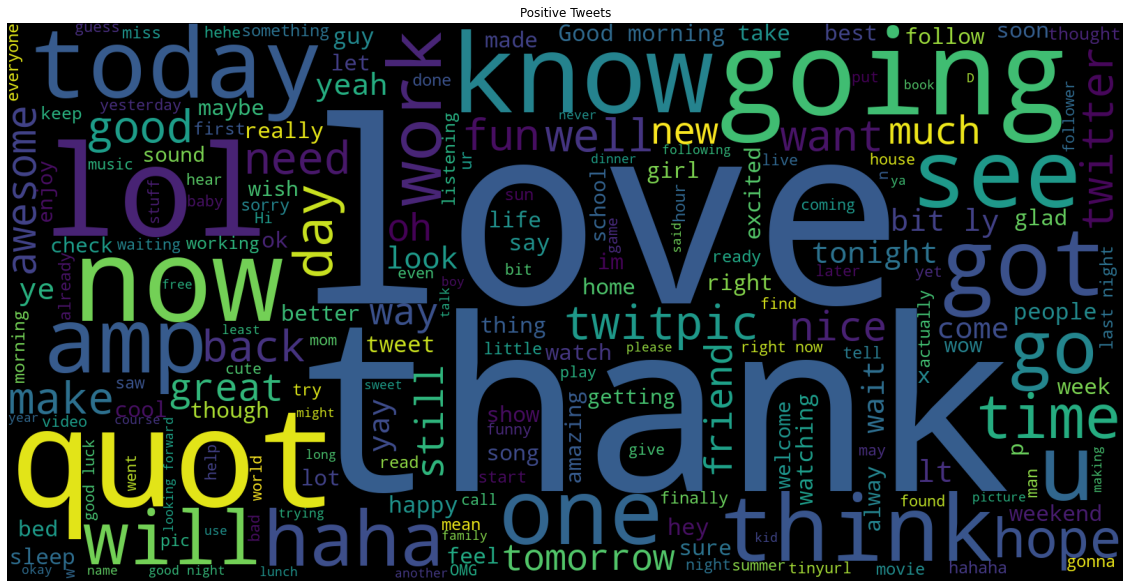

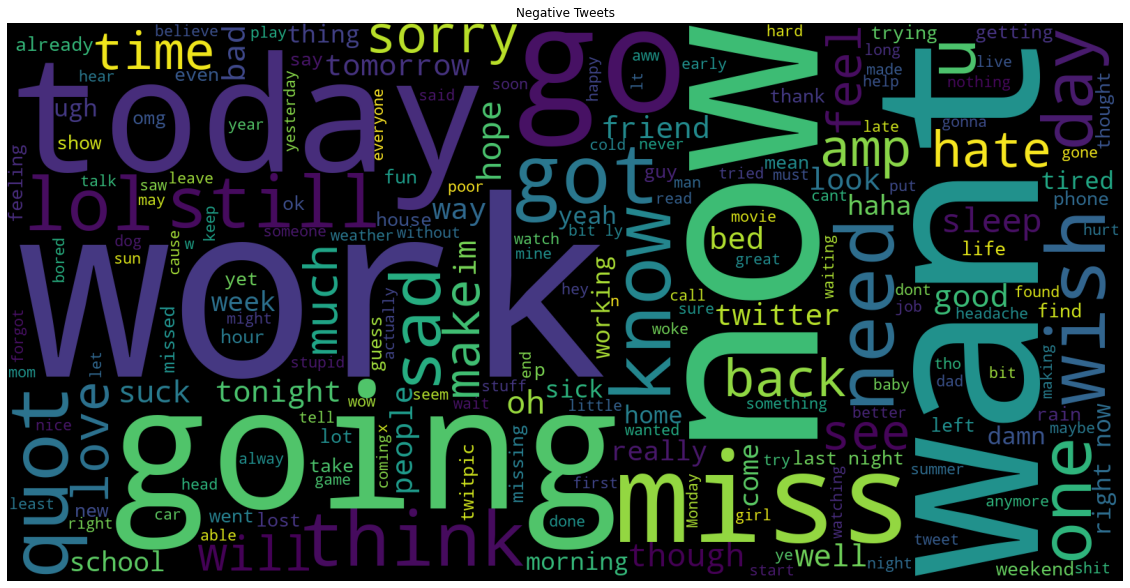

In [43]:
from wordcloud import WordCloud

df_pos = df.loc[df["Label"] == 1]
df_neg = df.loc[df["Label"] == 0]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["Text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["Text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()

In [44]:
# Add common words as stopwords
n_sw = 50 # Add n_sw of the top common words as stop words
top_pos = list(wc_pos.words_.keys()) # Sorted in decr order of frequencies, len=200
top_neg = list(wc_neg.words_.keys())
common = list(set(top_pos[:n_sw]) & set(top_neg[:n_sw]))
print(common)

['much', 'u', 'know', 'think', 'amp', 'back', 'still', 'want', 'need', 'will', 'look', 'love', 'got', 'oh', 'day', 'way', 'work', 'going', 'now', 'see', 'come', 'quot', 'friend', 'tomorrow', 'make', 'lol', 'well', 'twitter', 'good', 'go', 'time', 'today', 'tonight', 'one', 'hope']


In [45]:
# Only select some, as others are meaningful
common = ["amp", "quot", "lol" "u"]

In [46]:
import re
import nltk
nltk.download('stopwords')
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer

puncs = string.punctuation
sw = stopwords.words("english") # Not used as it contains "don't" "not" "did't" which are "negative" and will change the meaning of the sentence
sb = SnowballStemmer(language = "english") # Better and faster than PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions (@username), all URLs, all hashtags.  (\S+ matches with everything that is not a whitespace)
    text = re.sub("@\S+|http\S+|#\S+", "", text)
    # Remove punctuations (Redundant step, handled later in Keras tokenizer)
    text.translate(str.maketrans('', '', puncs))
    # Strip off accents (convert to ascii)
    text = unidecode(text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Don't stem as overlap with embeddings vocab is close to 0 
    # DON'T remove stop words as they carry imp info about the meaning of the sentence and non-alphanumeric tokens
    cleaned_tokens = [t for t in tokenized_text if t.isalnum() and t not in common]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wzengad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
from tqdm import tqdm
tqdm.pandas()
nltk.download('punkt')

def cleanDF(df):
    df["Text"] = df["Text"].progress_apply(lambda x : preprocess(x))
    return df

[nltk_data] Downloading package punkt to /home/wzengad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
# This takes a lot of time
df = cleanDF(df)
display(df)

100%|██████████| 1600000/1600000 [04:55<00:00, 5418.64it/s]


,Label,Text
541200,0,ahhh i hope your ok
750,0,cool i have no tweet apps for my razr 2
766711,0,i know just family drama its next time u hang ...
285055,0,school email wo open and i have geography stuf...
705995,0,upper airways problem
...,...,...
259178,0,this song middle change just does want to be b...
1414414,1,good luck with that
131932,0,i rather average 32370
671155,0,pickin up waitin on 2 hurry up i odeeee missed...


## Analyze the length of the tweets:
This will help us select the `N_SEQ`

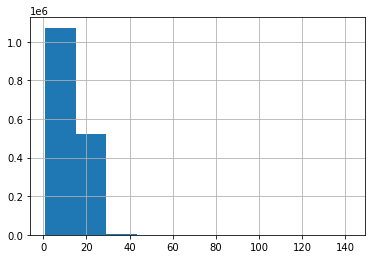

Mean: 12.4885
Std: 6.9047
Mean+3*Std = 33.2026


In [49]:
lengths = df["Text"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean:.4f}\nStd: {std:.4f}\nMean+3*Std = {approx_nseq:.4f}")

Thus we keep `N_SEQ = 32` (Power of 2)

In [50]:
N_SEQ = 32

## Preparation before model training
Doing this in Keras is quite simple and intuitive

In [51]:
from sklearn.model_selection import train_test_split as tts

# Split into training and validation sets
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

Below stuff can be done using `numpy` as well, but Keras is being used just for simplicity

In [52]:
from keras.preprocessing.text import Tokenizer

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(df_train["Text"])
    return tok

In [53]:
tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1 # +1 for the 0 padding
print(N_vocab)

252081


In [54]:
from keras.preprocessing.sequence import pad_sequences

def getXY(tok):
    x_train = pad_sequences(tok.texts_to_sequences(df_train["Text"]), maxlen = N_SEQ, padding = "post")
    x_val   = pad_sequences(tok.texts_to_sequences(df_val["Text"]), maxlen = N_SEQ, padding = "post")
    y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
    y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)
    return x_train, x_val, y_train, y_val

In [55]:
x_train, x_val, y_train, y_val = getXY(tok) # All are nice numpy arrays

## Preparing the Embeddings

In [56]:
import torch

In [57]:
# Maps each word in the embeddings vocabulary to it's embedded representation 
embeddings_index = {}
with open(PATH_EMB, "r", errors="ignore") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

673969it [00:31, 21128.29it/s]


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [59]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(0, 1, (N_EMB,))
print("Vocabulary match: ", n_match)

# Convert to torch tensor to be used directly in the embedding layer:
embeddings_tensor = torch.FloatTensor(embedding_matrix).to(device)

Vocabulary match:  99944


In [60]:
from torch.utils.data import DataLoader, TensorDataset

# Data ready to be loaded:
data_train = TensorDataset(torch.from_numpy(x_train).long(), torch.from_numpy(y_train).long())
data_val = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())

In [61]:
N_BATCH = 128

# Create dataloaders, we have already shuffled our data
loader_train = DataLoader(data_train, shuffle = False, batch_size = N_BATCH)
loader_val = DataLoader(data_val, shuffle = False, batch_size = N_BATCH)

## The Model:
Based on [this](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb) tutorial

In [62]:
N_EPOCHS = 20
OUTPUT_DIM = 1
HIDDEN_DIM = 64 # Output dimension of the LSTM
lr=0.0001

### Utility functions:

In [63]:
def countParameters(model):
    """ Counts the total number of trainiable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

In [64]:
import torch.nn.functional as F

def binary_accuracy(logits, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # Round predictions to the closest integer
    preds = torch.sigmoid(logits)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [65]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [66]:
def train(model, iterator, optimizer, criterion):
    """ Trains the model on the given training set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Tells your model that you are training the model
    
    for text, labels in iterator:
        
        # https://discuss.pytorch.org/t/how-to-add-to-attribute-to-dataset/86468
        text = text.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # Zero the previous gradients
        
        logits = model(text)
        labels = labels.type_as(logits)
        
        loss = criterion(logits, labels)
        acc = binary_accuracy(logits, labels)
        
        loss.backward() # Compute gradients
        
        optimizer.step() # Make the updates
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [67]:
def evaluate(model, iterator, criterion):
    """ Evaluates the model on the validation set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # Tells the model that we are currently evaluating the model
    
    with torch.no_grad(): # Temporarily set all the requires_grad flag to false
    
        for text, labels in iterator:
            
            text = text.to(device)
            labels = labels.to(device)

            logits = model(text)
            labels = labels.type_as(logits)
            
            loss = criterion(logits, labels)
            acc = binary_accuracy(logits, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [68]:
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout = 0.2):
        
        super().__init__()
        # Embedding
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, freeze = True)
        # BiLSTM
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 1,
            bidirectional = True, 
            # dropout = dropout, # adds dropout on the connections between hidden states in one layer to hidden states in the next layer.
            batch_first = True
        )
        # Multihead attention:
        self.mha = nn.MultiheadAttention(2*hidden_dim, num_heads = 8)
        # Flatten into [batch_size, 2*N_HIDDEN*N_SEQ]
        self.flatten = nn.Flatten() 
        # Fully connected classifer
        self.fc1 = nn.Linear(N_SEQ*2*hidden_dim, 1024) # As bidirectional
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, output_dim)
        
    def forward(self, text):
        # Embedding of the given "text" represented as a vector
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        # LSTM output
        lstm_output, (ht, cell) = self.lstm(embedded) # [batch size, sent len, hid dim], [ batch size, 1, hid dim]
        # Compute attention:
        attn_output, attn_output_weights = self.mha(lstm_output, lstm_output, lstm_output)
        # Flatten:
        x = self.flatten(attn_output)
        # Classifer:
        # Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        # Dropout
        x = self.dropout(x)
        # Layer 2
        x = self.fc2(x)
        x = F.relu(x)
        # Layer 3
        x = self.fc3(x)
        x = F.relu(x)
        # Output layer
        output = self.fc4(x)
        
        return output # No need for sigmoid, our loss function will apply that for us

In [69]:
model = Model(N_vocab, N_EMB, HIDDEN_DIM, OUTPUT_DIM)
trainable, frozen = countParameters(model)

print(model)
print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

Model(
  (embedding): Embedding(252081, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
The model has 4,668,225 trainable parameters and 50,416,200 frozen parameters


In [70]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss() # Binary crossentropy: This computes sigma(logits) too, much more numerically stable

In [71]:
# Place on GPU if available
model = model.to(device)
criterion = criterion.to(device)

In [72]:
# The actual training and validation:

best_valid_loss = float("inf")

history = {
    "t_loss" : [],
    "v_loss" : [],
    "t_acc" : [],
    "v_acc" : []
}

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, loader_val, criterion)
    
    end_time = time.time()
    
    history["t_loss"].append(train_loss)
    history["v_loss"].append(valid_loss)
    history["t_acc"].append(train_acc)
    history["v_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves best only
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
    
    # Print details about each epoch:
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 1m 35s
	Train Loss: 0.469 | Train Acc: 77.09%
	 Val. Loss: 0.434 |  Val. Acc: 79.72%
Epoch: 02 | Epoch Time: 1m 34s
	Train Loss: 0.426 | Train Acc: 80.25%
	 Val. Loss: 0.419 |  Val. Acc: 80.62%
Epoch: 03 | Epoch Time: 1m 34s
	Train Loss: 0.413 | Train Acc: 81.03%
	 Val. Loss: 0.410 |  Val. Acc: 81.09%
Epoch: 04 | Epoch Time: 1m 34s
	Train Loss: 0.404 | Train Acc: 81.54%
	 Val. Loss: 0.405 |  Val. Acc: 81.48%
Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 0.397 | Train Acc: 81.91%
	 Val. Loss: 0.401 |  Val. Acc: 81.76%
Epoch: 06 | Epoch Time: 1m 34s
	Train Loss: 0.391 | Train Acc: 82.23%
	 Val. Loss: 0.397 |  Val. Acc: 81.93%
Epoch: 07 | Epoch Time: 1m 33s
	Train Loss: 0.386 | Train Acc: 82.50%
	 Val. Loss: 0.395 |  Val. Acc: 82.09%
Epoch: 08 | Epoch Time: 1m 34s
	Train Loss: 0.382 | Train Acc: 82.75%
	 Val. Loss: 0.392 |  Val. Acc: 82.23%
Epoch: 09 | Epoch Time: 1m 34s
	Train Loss: 0.378 | Train Acc: 82.96%
	 Val. Loss: 0.391 |  Val. Acc: 82.39%
Epoch: 10 | Epoch T

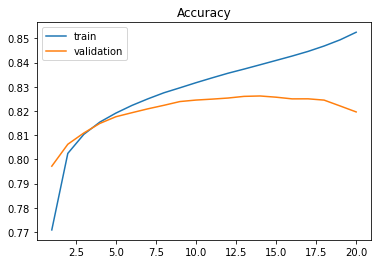

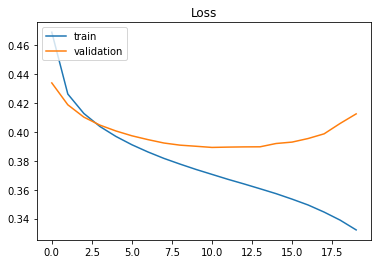

In [73]:
# Plots

t_acc = history["t_acc"]
t_loss = history["t_loss"]
v_acc = history["v_acc"]
v_loss = history["v_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [75]:
# test with some tweets

test_tweet = pad_sequences(tok.texts_to_sequences(df_train["Text"][:3]), maxlen = N_SEQ, padding = "post")
test_tweet_label = df_train["Label"][:3].to_numpy(dtype = float).reshape(-1, 1)
test_tweet=torch.from_numpy(test_tweet).long().to(device)
test_tweet_pred=torch.round(torch.sigmoid(model(test_tweet))).cpu().detach().numpy()

for i in range(3):
    print(f' {df_train["Text"].iloc[i]} : predicted label {test_tweet_pred[i]}, true label {test_tweet_label[i]}')


 wish i didnt have to go to work : predicted label [1.], true label [0.]
 i too am thrilled to be one of the 181 fp followers i know its a bit selfish : predicted label [1.], true label [1.]
 i think i going to have to put my dog down : predicted label [1.], true label [0.]
